In [22]:
import db_logger
import matplotlib.pyplot as plt
import glob, pathlib
import ipywidgets as widgets
import numpy as np
%load_ext autoreload
%autoreload 2

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:

logger =  db_logger.DB_Logger("/mnt/data/arty/data/gan_sampling/baseline.db", connect_only=True)
name2id = {}
for id in logger.get_experiment_ids():
    name = logger.get_experiment_name(id)
    name2id[name] = id
    # if "alvl3" in name:
    #     print(name) 
    #     logger.remove_experiment(id)

Connecting to existing database at /mnt/data/arty/data/gan_sampling/baseline.db


In [24]:
results = {}
from collections import defaultdict
# Your data (accuracy, std, rlvl, b, aug)
data = defaultdict(list)
for exp in logger.get_experiment_ids():
    samples = logger.get_global_stats(exp)
    if len(samples) == 0:
        continue
    name = logger.get_experiment_name(exp)
    # print(name, mean, std, max, min, samples)
    results[f"{name:<30}, samples: {len(samples):<3}"] = (samples.mean().item(), samples.std().item(), samples.max().item(), samples.min().item(), len(samples))
    name, rlvl, blvl, alvl = name.split("_")
    rlvl = int(rlvl[-1])
    alvl = int(alvl[-1])
    blvl = int(blvl[-1])

    data[name].append((samples, rlvl, blvl, alvl))
    


In [25]:
sorted_results = sorted(results.items(), key=lambda x: x[1][0], reverse=True)
filterfunc = lambda x: "B" in x[0] 
sorted_results = list(filter(filterfunc, sorted_results))
for k, (mean, std, max, min, samples) in sorted_results[:40]:
    print(f"{mean:.3f}+-{std:.3f} -> {k} max: {max:.3f}")

0.945+-0.040 -> BloodMNIST_rlvl0_blvl1_alvl1  , samples: 8   max: 0.964
0.943+-0.055 -> BloodMNIST_rlvl0_blvl0_alvl1  , samples: 9   max: 0.966
0.942+-0.008 -> BloodMNIST_rlvl0_blvl1_alvl2  , samples: 7   max: 0.952
0.941+-0.005 -> BloodMNIST_rlvl0_blvl0_alvl2  , samples: 6   max: 0.949
0.923+-0.018 -> BloodMNIST_rlvl0_blvl1_alvl0  , samples: 11  max: 0.938
0.916+-0.030 -> BloodMNIST_rlvl0_blvl0_alvl0  , samples: 11  max: 0.933
0.904+-0.003 -> BloodMNIST_rlvl0_blvl1_alvl3  , samples: 2   max: 0.907
0.896+-0.051 -> BloodMNIST_rlvl1_blvl1_alvl1  , samples: 6   max: 0.939
0.893+-0.055 -> BloodMNIST_rlvl1_blvl0_alvl1  , samples: 10  max: 0.931
0.877+-0.053 -> BloodMNIST_rlvl1_blvl1_alvl2  , samples: 8   max: 0.907
0.857+-0.088 -> BloodMNIST_rlvl1_blvl0_alvl2  , samples: 7   max: 0.900
0.856+-0.012 -> BloodMNIST_rlvl1_blvl1_alvl0  , samples: 13  max: 0.880
0.847+-0.008 -> BloodMNIST_rlvl1_blvl1_alvl3  , samples: 2   max: 0.856
0.847+-0.023 -> BloodMNIST_rlvl1_blvl0_alvl0  , samples: 13  max

interactive(children=(Dropdown(description='exp1', options=('BloodMNIST_rlvl0_blvl0_alvl0', 'BloodMNIST_rlvl0_…

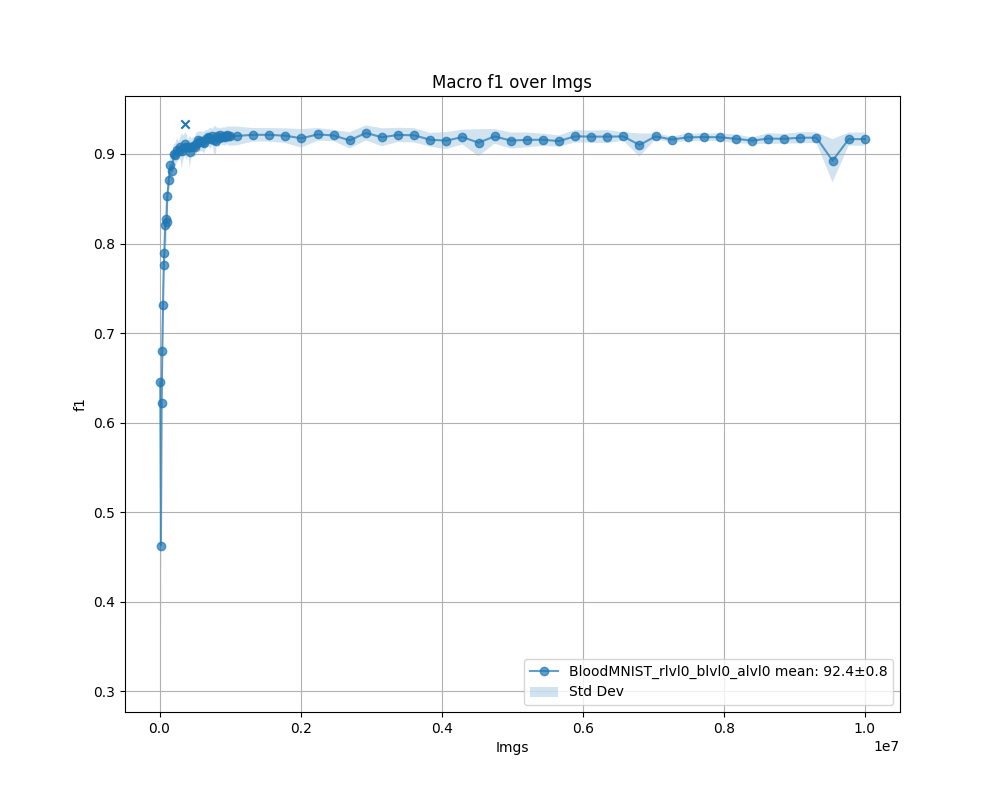

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
names = sorted([logger.get_experiment_name(x) for x in logger.get_experiment_ids()],)
@widgets.interact(
        exp1=names, 
        exp2=["none"]+names, 
        exp3=["none"]+names,
        exp4=["none"]+names,
        exp5=["none"]+names,
        exp6=["none"]+names, 
        exp7=["none"]+names,
        exp8=["none"]+names,
        metric=["f1", "acc", "precision", "recall"])
def display_content(exp1, exp2, exp3, exp4, exp5, exp6, exp7, exp8, metric):
    name2id = {}
    for id in logger.get_experiment_ids():
        name2id[logger.get_experiment_name(id)] = id
    print(f"Working ...", end="")
    ax.clear()
    db_logger.plot_metric(logger, [name2id[exp1]], metric=metric, ax=ax, prefix='')
    if exp2 != "none":
        db_logger.plot_metric(logger, [name2id[exp2]], metric=metric, ax=ax, prefix='')
    if exp3 != "none":
        db_logger.plot_metric(logger, [name2id[exp3]], metric=metric, ax=ax, prefix='')
    if exp4 != "none":
        db_logger.plot_metric(logger, [name2id[exp4]], metric=metric, ax=ax, prefix='')
    if exp5 != "none":
        db_logger.plot_metric(logger, [name2id[exp5]], metric=metric, ax=ax, prefix='')
    if exp6 != "none":
        db_logger.plot_metric(logger, [name2id[exp6]], metric=metric, ax=ax, prefix='')
    if exp7 != "none":
        db_logger.plot_metric(logger, [name2id[exp7]], metric=metric, ax=ax, prefix='')
    if exp8 != "none":
        db_logger.plot_metric(logger, [name2id[exp8]], metric=metric, ax=ax, prefix='')
    print(f"\rDone       ")

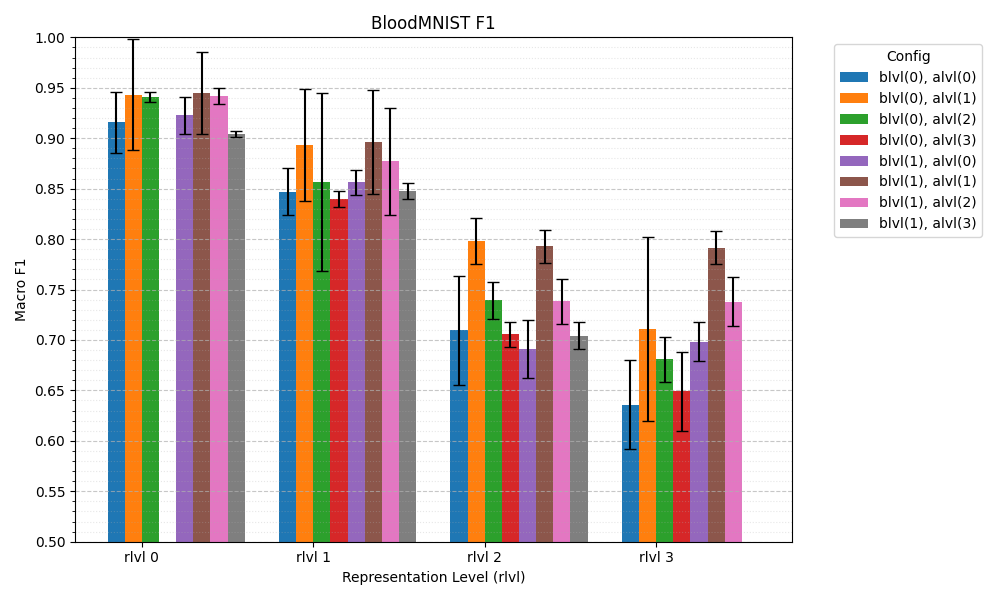

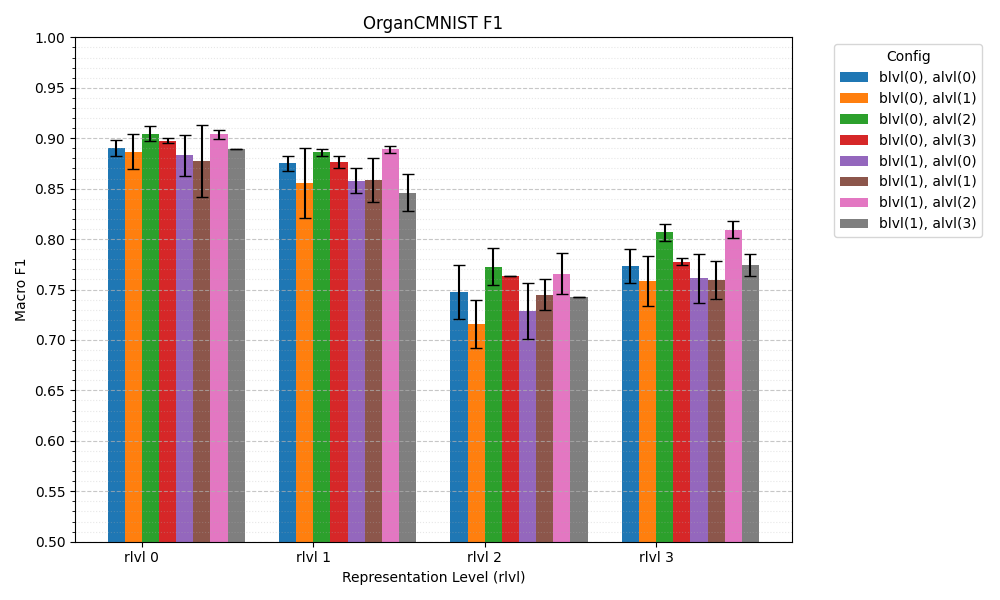

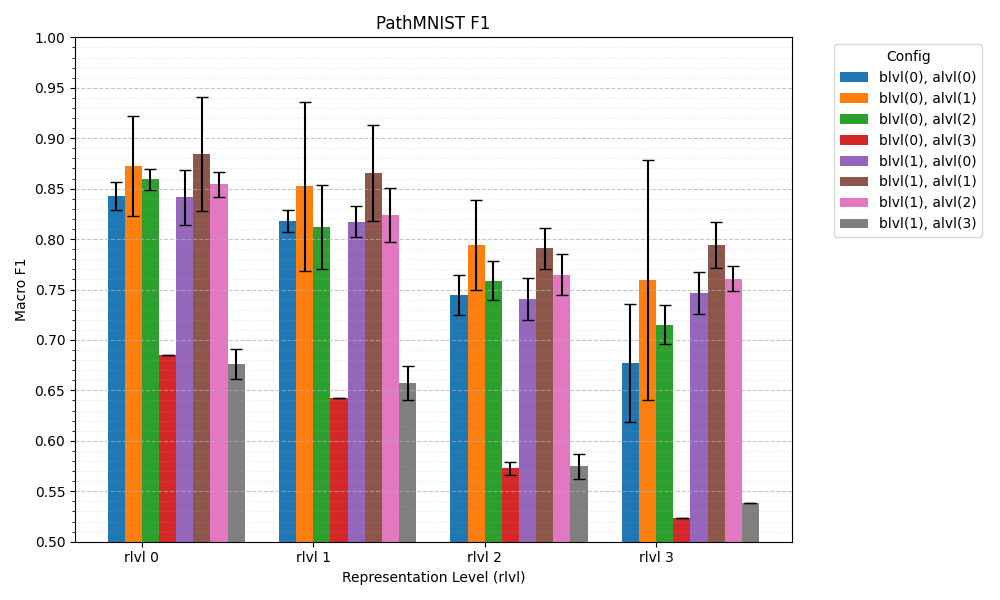

In [26]:
config_labels = {
    (0, 0): "blvl(0), alvl(0)",
    (0, 1): "blvl(0), alvl(1)",
    (0, 2): "blvl(0), alvl(2)",
    (0, 3): "blvl(0), alvl(3)",
    (1, 0): "blvl(1), alvl(0)",
    (1, 1): "blvl(1), alvl(1)",
    (1, 2): "blvl(1), alvl(2)",
    (1, 3): "blvl(1), alvl(3)",
}

# Organize data
means_by_group = {rlvl: {cfg: 0.0 for cfg in config_labels} for rlvl in range(4)}
stds_by_group = {rlvl: {cfg: 0.0 for cfg in config_labels} for rlvl in range(4)}
# Mapping config combinations to label
for name, d in data.items():

    for v, rlvl, blvl, alvl in d:
        key = (blvl, alvl)
        means_by_group[rlvl][key] = v.mean()
        stds_by_group[rlvl][key] = v.std()

    # Bar plot setup
    x = np.arange(4)  # rlvl 0,1,2,3
    width = 0.1

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, config in enumerate(config_labels):
        means = [means_by_group[rlvl][config] for rlvl in x]
        stds = [stds_by_group[rlvl][config] for rlvl in x]
        offsets = x + (i - 1.5) * width
        ax.bar(offsets, means, width, yerr=stds, capsize=4, label=config_labels[config])

    # Aesthetics
    ax.set_ylabel('Macro F1')
    ax.set_xlabel('Representation Level (rlvl)')
    ax.set_title(f'{name} F1')
    ax.set_xticks(x)
    ax.set_xticklabels([f'rlvl {i}' for i in x])
    ax.set_ylim(0.5, 1.0)
    ax.legend(title="Config", bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))  
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.01)) 
    ax.grid(which='major', axis='y', linestyle='--', alpha=0.7)
    ax.grid(which='minor', axis='y', linestyle=':', alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{name}_bar.png")

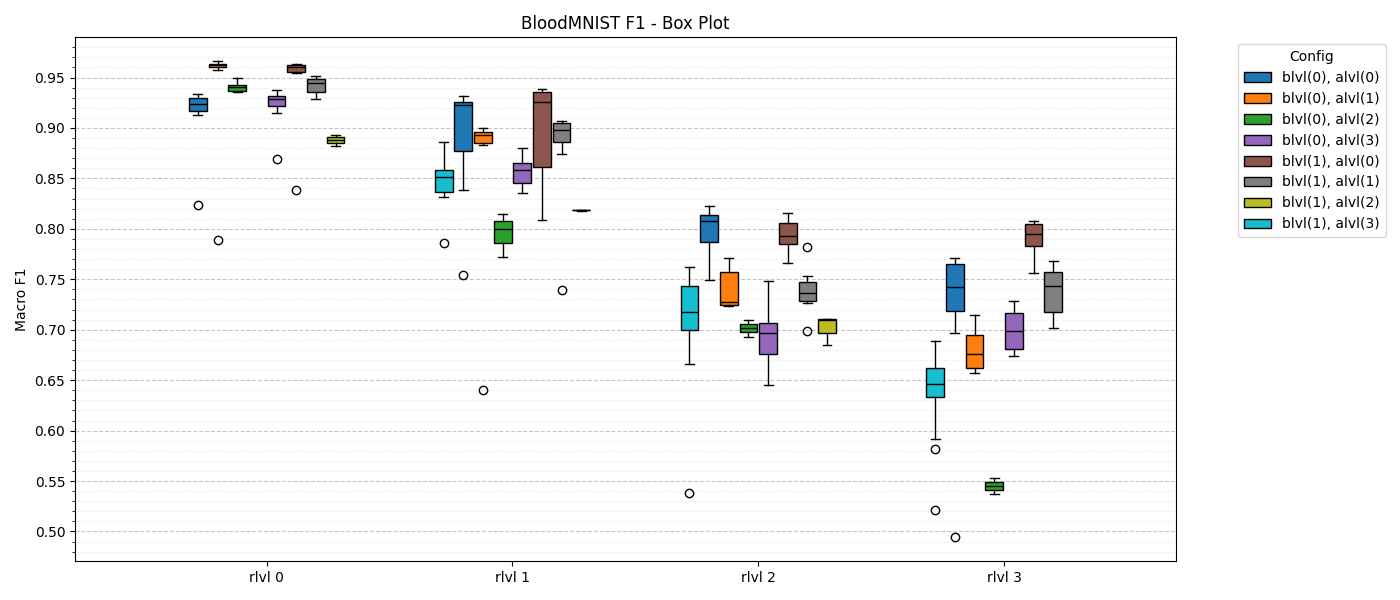

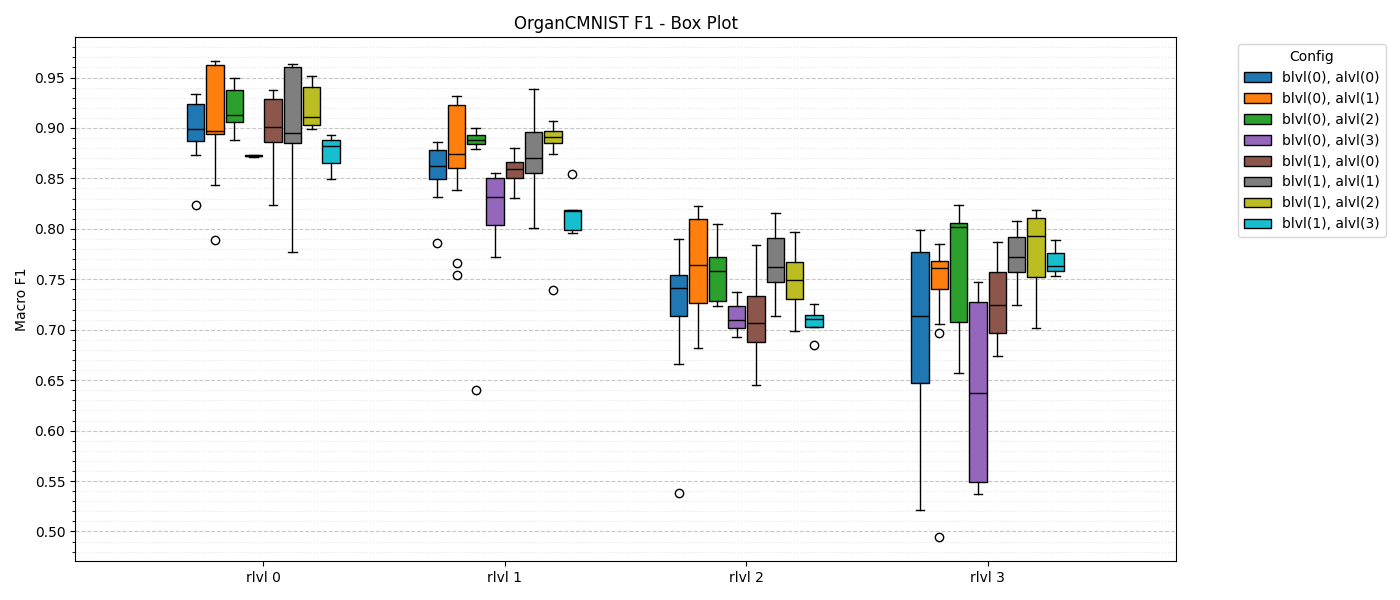

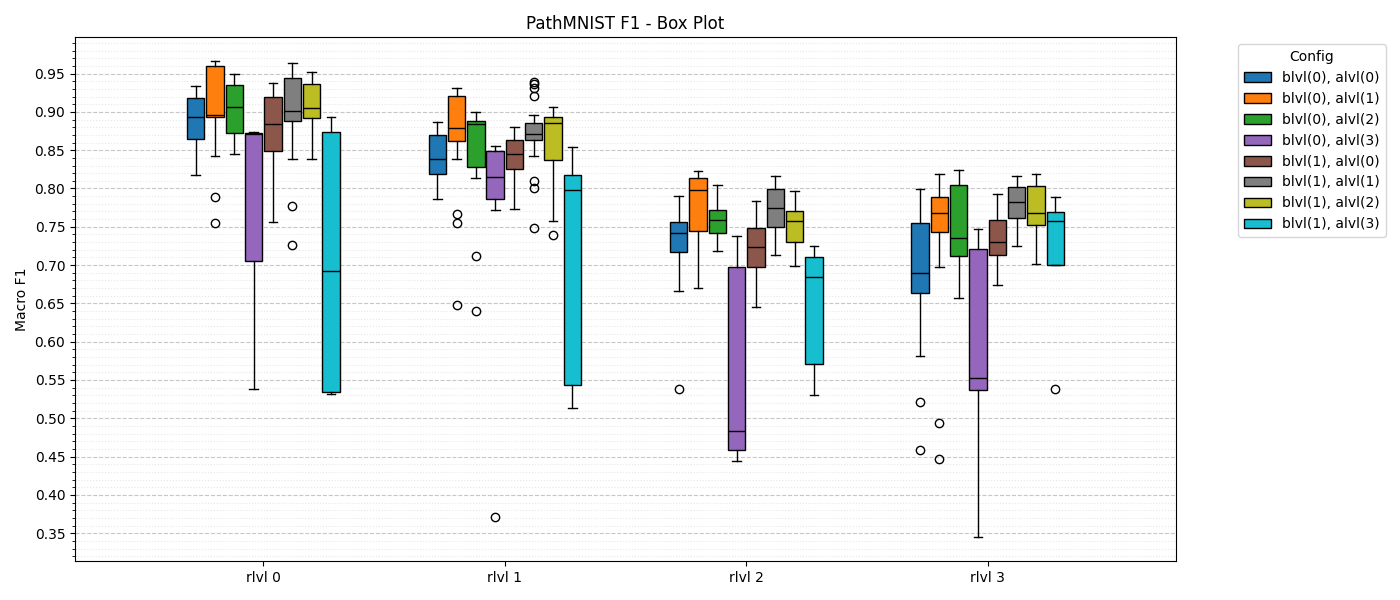

In [21]:
from matplotlib.patches import Patch
config_labels = {
    (0, 0): "blvl(0), alvl(0)",
    (0, 1): "blvl(0), alvl(1)",
    (0, 2): "blvl(0), alvl(2)",
    (0, 3): "blvl(0), alvl(3)",
    (1, 0): "blvl(1), alvl(0)",
    (1, 1): "blvl(1), alvl(1)",
    (1, 2): "blvl(1), alvl(2)",
    (1, 3): "blvl(1), alvl(3)",
}

# Step 1: Organize raw data by (rlvl, config)
all_data_by_group = {rlvl: {cfg: [] for cfg in config_labels} for rlvl in range(4)}

for name, d in data.items():
    for v, rlvl, blvl, alvl in d:
        key = (blvl, alvl)
        all_data_by_group[rlvl][key].extend(v.tolist())  # Collect raw values

    fig, ax = plt.subplots(figsize=(14, 6))

    # Step 2: Prepare boxplot data
    positions = []
    box_data = []
    labels = []
    width = 0.08

    for rlvl in range(4):
        for i, config in enumerate(config_labels):
            values = all_data_by_group[rlvl][config]
            if values:
                pos = rlvl + (i - 3.5) * width  # Spread the boxes within each rlvl
                positions.append(pos)
                box_data.append(values)
                labels.append(f'rlvl {rlvl}\n{config_labels[config]}')

    # Step 3: Create boxplot
    bp = ax.boxplot(
        box_data,
        positions=positions,
        patch_artist=True,
        widths=width * 0.9,
        showfliers=True,
        medianprops=dict(color='black')
    )

    # Coloring boxes (optional)
    colors = plt.cm.tab10(np.linspace(0, 1, len(config_labels)))
    for patch, color in zip(bp['boxes'], colors.tolist() * 4):
        patch.set_facecolor(color)

    # Step 4: Aesthetics
    ax.set_xticks([i for i in range(4)])
    ax.set_xticklabels([f"rlvl {i}" for i in range(4)])
    ax.set_ylabel('Macro F1')
    ax.set_title(f'{name} F1 - Box Plot')
    # ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))  
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.01)) 
    ax.grid(which='major', axis='y', linestyle='--', alpha=0.7)
    ax.grid(which='minor', axis='y', linestyle=':', alpha=0.3)

    # Assign colors to each config
    config_colors = {cfg: color for cfg, color in zip(config_labels, plt.cm.tab10(np.linspace(0, 1, len(config_labels))))}

    # Update box colors and build legend handles
    legend_handles = []

    for i, patch in enumerate(bp['boxes']):
        config = list(config_labels.keys())[i % len(config_labels)]
        color = config_colors[config]
        patch.set_facecolor(color)
        
        # Only add one handle per config
        if i < len(config_labels):  
            legend_handles.append(Patch(facecolor=color, edgecolor='black', label=config_labels[config]))

    # Add legend
    ax.legend(handles=legend_handles, title="Config", bbox_to_anchor=(1.05, 1), loc='upper left')
        

    plt.tight_layout()
    plt.savefig(f"{name}_box.png")